/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide


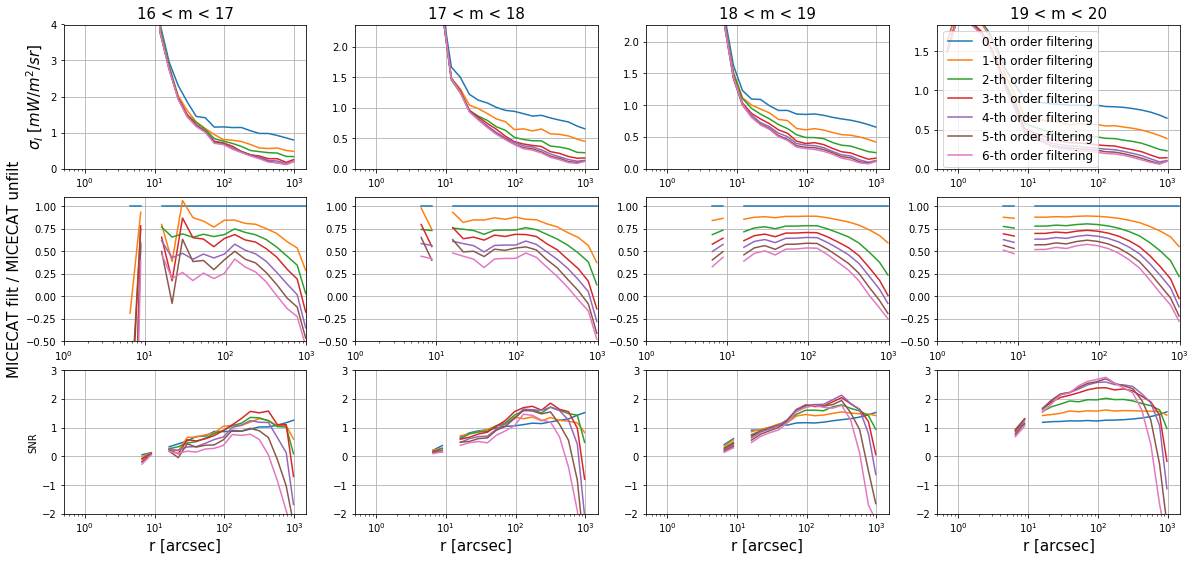

In [4]:
from stack import *
from micecat_auto import *

for inst in [1]:
    data = {}
    fig, ax = plt.subplots(3, 4, figsize = (20,9))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        data[im] = {}
        for filt_order in range(7):
            data[im][filt_order] = {}
            rbins, mc_avg0, _, _ = get_micecat_sim_auto(inst, im, filt_order=0, sub=False)
            _, mc_avg, _, _ = get_micecat_sim_auto(inst, im, filt_order=filt_order, sub=False)
            sig_window = mc_avg / mc_avg0
            
            profd_arr, profd_err = 0, 0
            profdsub_arr, profdsub_err = 0, 0
            for ifield in [4,5,6,7,8]:
                stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                                    load_from_file=True,BGsub=False).stackdat
                profd_arri = stackdat['ex']['profcb']
                profd_erri = np.sqrt(np.diag(stackdat['excov']['profcb']))
                profd_arr += profd_arri / profd_erri**2
                profd_err += 1 / profd_erri**2
                profdsub_arri = stackdat['ex']['profcbsub']
                profdsub_erri = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
                profdsub_arr += profdsub_arri / profdsub_erri**2
                profdsub_err += 1 / profdsub_erri**2

            profd_arr /= profd_err
            profd_err = np.sqrt(1 / profd_err)
            profdsub_arr /= profdsub_err
            profdsub_err = np.sqrt(1 / profdsub_err)
            
            rbins, mc_avg0, _, _ = get_micecat_sim_auto(inst, im, filt_order=0, sub=False)
            _, mc_avg, _, _ = get_micecat_sim_auto(inst, im, filt_order=filt_order, sub=False)
            
            ax[0][im].semilogx(rbins, profd_err, label='%d-th order filtering'%filt_order)
            ax[1][im].semilogx(rbins, sig_window)
            ax[2][im].semilogx(rbins, sig_window/profd_err)
            
            data[im][filt_order]['rbins'] = rbins
            data[im][filt_order]['profd_arr'] = profd_arr
            data[im][filt_order]['profd_err'] = profd_err
            data[im][filt_order]['sig_window'] = sig_window
            
        ax[0][im].set_ylim([0,profd_err[-1]*20])
        ax[0][im].set_xlim([5e-1,1.5e3])
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[0][im].grid()    
        ax[1][im].set_ylim([-0.5,1.1])
        ax[1][im].set_xlim([1e0,1e3])
        ax[1][im].grid()    
        ax[2][im].set_ylim([-2,3])
        ax[2][im].set_xlim([5e-1,1.5e3])
        ax[2][im].grid()
        ax[2][im].set_xlabel('r [arcsec]', fontsize=15)

    ax[0][0].set_ylabel(r'$\sigma_I$ [$mW/m^2/sr$]', fontsize=15)
    ax[1][0].set_ylabel('MICECAT filt / MICECAT unfilt', fontsize=15)
    ax[2][0].set_ylabel('SNR', fontsize=10)
    ax[0][-1].legend(fontsize=12)
    plt.savefig('/Users/ytcheng/Desktop/profile_TM%d_filt.png'%(inst),
                dpi = 200, bbox_inches='tight')

$SNR_{\rm tot} = \sqrt{\sum_i SNR_i^2}$ 

/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


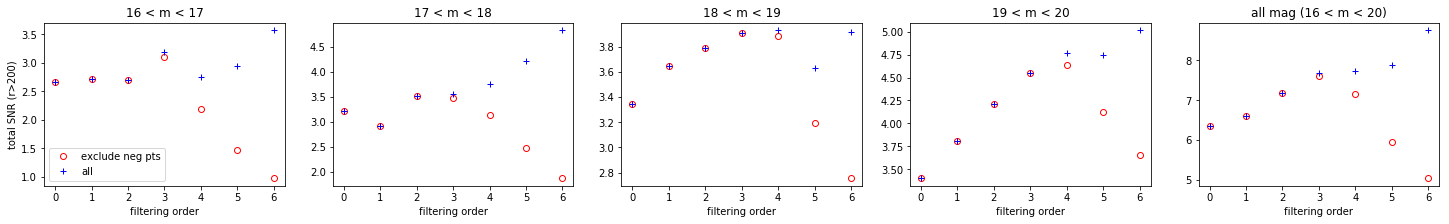

In [2]:
rmin = 200
fig, ax = plt.subplots(1, 5, figsize = (25,3))
for filt in list(data[im]):
    snrtot_all, snrtot_neg_all = 0, 0
    for im in range(4):
        rbins = data[im][filt]['rbins']
        snr = data[im][filt]['sig_window']/data[im][filt]['profd_err']
        snrtot = np.sqrt(np.sum(snr[(rbins>rmin) & (snr>0)]**2))
        snrtot_neg = np.sqrt(np.sum(snr[(rbins>rmin)]**2))
        snrtot_all += snrtot**2
        snrtot_neg_all += snrtot_neg**2
        ax[im].plot(filt, snrtot, 'ro', markerfacecolor='None')
        ax[im].plot(filt, snrtot_neg, 'b+')
        ax[im].set_xlabel('filtering order')
        ax[im].set_title('%d < m < %d'%(magbindict['m_min'][im], magbindict['m_max'][im]))
    ax[0].set_ylabel('total SNR (r>{})'.format(rmin))
    ax[-1].plot(filt, np.sqrt(snrtot_all), 'ro', markerfacecolor='None')
    ax[-1].plot(filt, np.sqrt(snrtot_neg_all), 'b+')
    ax[0].legend({'exclude neg pts','all'})
    ax[-1].set_xlabel('filtering order')
    ax[-1].set_title('all mag (%d < m < %d)'%(magbindict['m_min'][0], magbindict['m_max'][-1]))
plt.savefig('/Users/ytcheng/Desktop/profile_SNRs_TM%d.png'%inst,
            dpi = 200, bbox_inches='tight')

# Compare data stack error: random jackknife v.s. regional jackknife

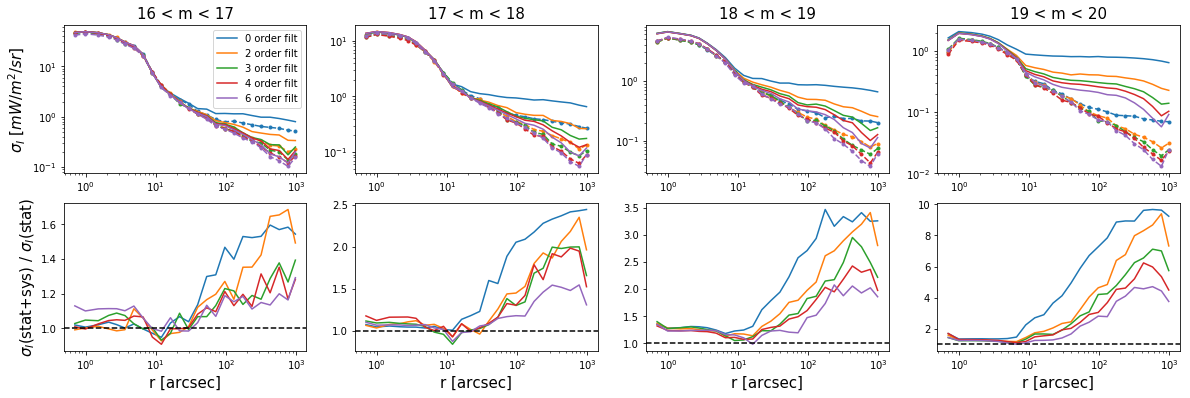

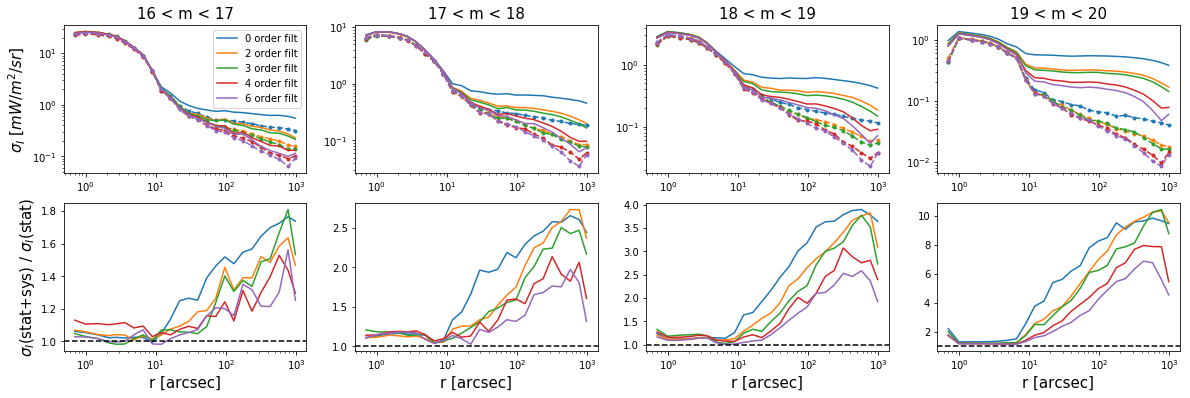

In [27]:
from stack import *

for inst in [1,2]:
    data = {}
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        data[im] = {}
        for filt_order in [0,2,3,4,6]:
            data[im][filt_order] = {}
            
            profd_arr, profd_err = 0, 0
            profdsub_arr, profdsub_err = 0, 0
            for ifield in [4,5,6,7,8]:
                stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                                    uniform_jack=False,load_from_file=True,BGsub=False).stackdat
                profd_arri = stackdat['ex']['profcb']
                profd_erri = np.sqrt(np.diag(stackdat['excov']['profcb']))
                profd_arr += profd_arri / profd_erri**2
                profd_err += 1 / profd_erri**2
                profdsub_arri = stackdat['ex']['profcbsub']
                profdsub_erri = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
                profdsub_arr += profdsub_arri / profdsub_erri**2
                profdsub_err += 1 / profdsub_erri**2

            profd_arr /= profd_err
            profd_err = np.sqrt(1 / profd_err)
            profdsub_arr /= profdsub_err
            profdsub_err = np.sqrt(1 / profdsub_err)
            
            data[im][filt_order]['jack_region'] = {}
            data[im][filt_order]['jack_region']['profd_arr'] = profd_arr
            data[im][filt_order]['jack_region']['profd_err'] = profd_err
            data[im][filt_order]['jack_region']['profdsub_arr'] = profdsub_arr
            data[im][filt_order]['jack_region']['profdsub_err'] = profdsub_err

            profd_arr, profd_err = 0, 0
            profdsub_arr, profdsub_err = 0, 0
            for ifield in [4,5,6,7,8]:
                stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                                    uniform_jack=True,load_from_file=True,BGsub=False,).stackdat
                profd_arri = stackdat['ex']['profcb']
                profd_erri = np.sqrt(np.diag(stackdat['excov']['profcb']))
                profd_arr += profd_arri / profd_erri**2
                profd_err += 1 / profd_erri**2
                profdsub_arri = stackdat['ex']['profcbsub']
                profdsub_erri = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
                profdsub_arr += profdsub_arri / profdsub_erri**2
                profdsub_err += 1 / profdsub_erri**2

            profd_arr /= profd_err
            profd_err = np.sqrt(1 / profd_err)
            profdsub_arr /= profdsub_err
            profdsub_err = np.sqrt(1 / profdsub_err)
            
            data[im][filt_order]['jack_random'] = {}
            data[im][filt_order]['jack_random']['profd_arr'] = profd_arr
            data[im][filt_order]['jack_random']['profd_err'] = profd_err
            data[im][filt_order]['jack_random']['profdsub_arr'] = profdsub_arr
            data[im][filt_order]['jack_random']['profdsub_err'] = profdsub_err

            data['rbins'] = stackdat['rbins']
            data['rsubbins'] = stackdat['rsubbins']
            
    fig, ax = plt.subplots(2, 4, figsize = (20,6))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        for i,filt_order in enumerate([0,2,3,4,6]):
            ax[0][im].loglog(data['rbins'],data[im][filt_order]['jack_region']['profd_err'],'C'+str(i),
                            label='%d order filt'%filt_order)
            ax[0][im].loglog(data['rbins'],data[im][filt_order]['jack_random']['profd_err'],
                             'C'+str(i)+'.--')
            ratio = data[im][filt_order]['jack_region']['profd_err'] /\
            data[im][filt_order]['jack_random']['profd_err']
            ax[1][im].semilogx(data['rbins'],ratio)
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[1][im].axhline(1,c='k',ls='--')
        ax[1][im].set_xlabel('r [arcsec]', fontsize=15)
    ax[0][0].set_ylabel(r'$\sigma_I$ [$mW/m^2/sr$]', fontsize=15)
    ax[0][0].legend()
    ax[1][0].set_ylabel(r'$\sigma_I$(stat+sys) / $\sigma_I$(stat)', fontsize=15)
    plt.savefig('/Users/ytcheng/Desktop/profile_error_TM%d.png'%inst,
                dpi = 200, bbox_inches='tight')

# Stack on Zemcov+14 Power Spectrum Map

In [4]:
from utils import *
from power_spec import *

In [2]:
from reduction import *
inst = 1
ifield = 8
data_maps = {1: image_reduction(1), 2: image_reduction(2)}
cbmap, strmask, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                   (inst,ifield,'strmask'), 
                                   (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])

mkk = mask_Mkk(mask_inst1*mask_inst2*strmask)
mkk.get_Mkk_sim(Nsims=10)
clear_output()
_,Cls0,Cls0err = get_power_spec(cbmap, mask=mask_inst1*mask_inst2*strmask)
Cls, Clserr = mkk.Mkk_correction(Cls0, Clerr=Cls0err)

In [7]:
lbins, Clsig, Clshot = sigCl_extrp_mz14()
lbins, _,_,_,lbinedges, _,_ = get_power_spec(np.ones([1024,1024]), return_full=True)
mapi = map_from_Cl(lbins, lbinedges, Clsig+Clshot, pixsize=7)
_, Clout, _ = get_power_spec(mapi)

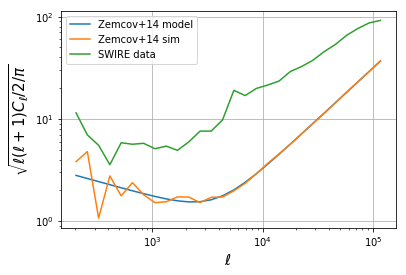

In [8]:
plt.loglog(lbins, np.sqrt((Clsig+Clshot)*lbins*(lbins+1)/2/np.pi), label='Zemcov+14 model')
plt.loglog(lbins, np.sqrt((Clout)*lbins*(lbins+1)/2/np.pi), label='Zemcov+14 sim')
plt.loglog(lbins, np.sqrt((Cls)*lbins*(lbins+1)/2/np.pi), label='SWIRE data')
plt.xlabel('$\ell$',fontsize=15)
plt.ylabel(r'$\sqrt{\ell(\ell+1)C_\ell/2/\pi}$',fontsize=15)
plt.legend()
plt.grid()
plt.savefig('/Users/ytcheng/Desktop/power_spec.png',
            dpi = 150, bbox_inches='tight')

### verifying the BG stack = src stack on large scale

Text(0, 0.5, '$\\sigma$')

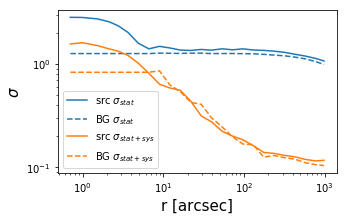

In [13]:
from stack import *
fig, ax = plt.subplots(1, 1, figsize = (5,3))
inst = 1
ifield = 8
filt_order=0
m_min, m_max = 19, 20
stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                    uniform_jack=False,load_from_file=True,BGsub=False).stackdat
ax.loglog(stackdat['rbins'],np.sqrt(np.diag(stackdat['cov']['profcb'])),'C0',label='src $\sigma_{stat}$')
ax.loglog(stackdat['rbins'],np.sqrt(np.diag(stackdat['BGcov']['profcb']))/8,'C0--',label='BG $\sigma_{stat}$')
stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                    uniform_jack=True,load_from_file=True,BGsub=False).stackdat
ax.loglog(stackdat['rbins'],np.sqrt(np.diag(stackdat['cov']['profcb'])),'C1',label='src $\sigma_{stat+sys}$')
ax.loglog(stackdat['rbins'],np.sqrt(np.diag(stackdat['BGcov']['profcb'])),'C1--',label='BG $\sigma_{stat+sys}$')
ax.legend()
ax.set_xlabel('r [arcsec]', fontsize=15)            
ax.set_ylabel(r'$\sigma$', fontsize=15)
# plt.savefig('/Users/ytcheng/Desktop/errors.png',
#             dpi = 150, bbox_inches='tight')

## Stack on Zemcov+14 Sim map

In [10]:
from stack import *
from stack_ancillary import *

inst = 1
ifield = 8
filt_order_arr = [0,1,2,3,4,5,6]
Nsub = 64

lbins, Clsig, Clshot = sigCl_extrp_mz14()
lbins, _,_,_,lbinedges, _,_ = get_power_spec(np.ones([1024,1024]), return_full=True)
mapi = map_from_Cl(lbins, lbinedges, Clsig+Clshot, pixsize=7)

mzdata = {}
for filt_order in filt_order_arr:
    mzdata[filt_order] = {}
    mapfi = image_poly_filter(mapi,degree=filt_order)
    
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        print('filt order %d, %d < m < %d'%(filt_order, m_min, m_max))
        mzdata[filt_order][im] = {}
        stackdat_ciber = stacking(inst, ifield, m_min, m_max, filt_order=0, 
                            load_from_file=True,BGsub=False).stackdat
        
        stack_class = stacking_mock(1, m_min, m_max)

        Nsides = int(np.sqrt(Nsub))
        axlims = np.linspace(-0.5, 1023.5, Nsides+1)
        ymins, xmins = np.meshgrid(axlims[:-1], axlims[:-1])
        ymaxs, xmaxs = np.meshgrid(axlims[1:], axlims[1:])

        profs_random = []
        profs_region = []
        prof_random_all, prof_region_all = 0,0
        Nsrc_sub_arr = []
        for isub in range(Nsub):
            Nsrc_sub = stackdat_ciber['sub'][isub]['Nsrc']
            Nsrc_sub_arr.append(Nsrc_sub)
            print(isub, Nsrc_sub)
            if Nsrc_sub == 0:
                profs_random.append(np.zeros_like(stackdat['rbins']))
                profs_region.append(np.zeros_like(stackdat['rbins']))
                continue
                
            xs = np.random.randint(-0.5,1023.5,Nsrc_sub)
            ys = np.random.randint(-0.5,1023.5,Nsrc_sub)
            stack_class.xls = xs
            stack_class.yls = ys
            stackdat = stack_class.run_stacking_bigpix(mapfi, np.ones_like(mapi),
                                                       np.zeros_like(mapi),verbose=False)
            profs_random.append(stackdat['prof'])
            prof_random_all += stackdat['prof']*Nsrc_sub
            
            ymin, xmin = ymins.flatten()[isub], xmins.flatten()[isub]
            ymax, xmax = ymaxs.flatten()[isub], xmaxs.flatten()[isub]
            xs = np.random.randint(xmin,xmax,Nsrc_sub)
            ys = np.random.randint(ymin,ymax,Nsrc_sub)
            stack_class.xls = xs
            stack_class.yls = ys
            stackdat = stack_class.run_stacking_bigpix(mapfi, np.ones_like(mapi),
                                                       np.zeros_like(mapi),verbose=False)
            profs_region.append(stackdat['prof'])
            prof_region_all += stackdat['prof']*Nsrc_sub
            
        profs_random, profs_region = np.array(profs_random), np.array(profs_region)
        Nsrc_sub_arr = np.array(Nsrc_sub_arr)
        
        profs_random_jack, profs_region_jack = np.zeros_like(profs_random), np.zeros_like(profs_region)
        for isub in range(Nsub):
            Ni = np.sum(Nsrc_sub_arr)-Nsrc_sub_arr[isub]
            profi = Nsrc_sub_arr[isub]*profs_random[isub,:]
            profs_random_jack[isub,:] = (prof_random_all - profi)/Ni
            profi = Nsrc_sub_arr[isub]*profs_region[isub,:]
            profs_region_jack[isub,:] = (prof_region_all - profi)/Ni


        mzdata[filt_order][im]['random_avg'] = np.mean(profs_random,axis=0)
        mzdata[filt_order][im]['random_std'] = np.sqrt(np.var(profs_random_jack,axis=0)*(Nsub-1))
        mzdata[filt_order][im]['region_avg'] = np.mean(profs_region,axis=0)
        mzdata[filt_order][im]['region_std'] = np.sqrt(np.var(profs_region_jack,axis=0)*(Nsub-1))

        clear_output()
mzdata['rbins'] = stackdat['rbins']
np.save('./filt_test_mzdata',mzdata)

Text(0, 0.5, '$\\sigma_I$')

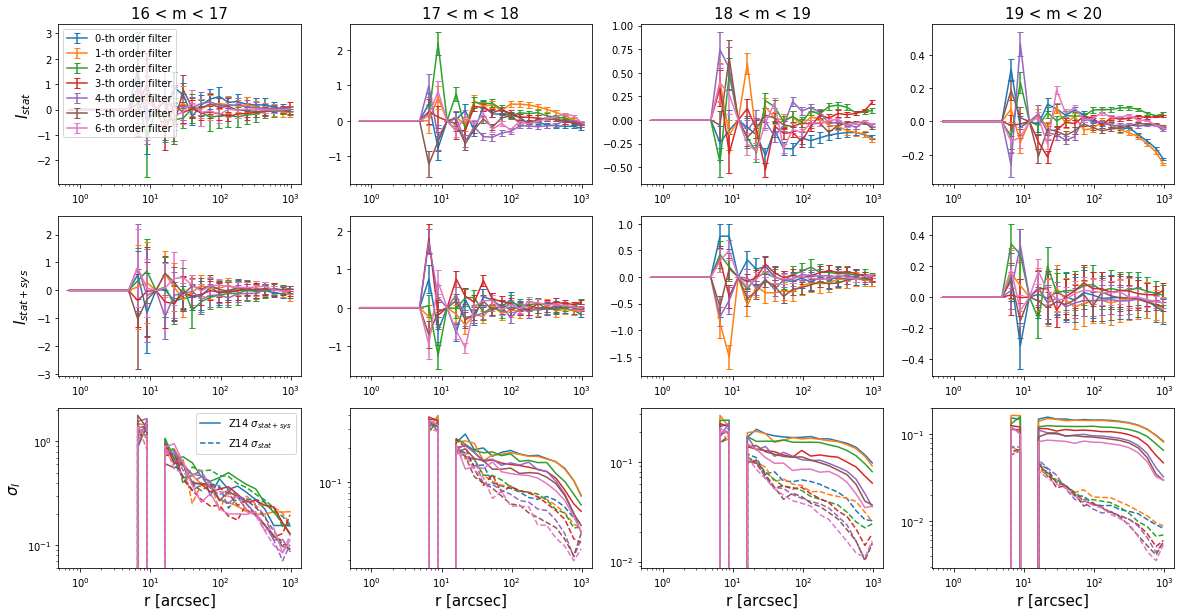

In [12]:
from utils import *
mzdata = np.load('./filt_test_mzdata' + '.npy' ,allow_pickle='TRUE').item()
filt_order_arr = [0,1,2,3,4,5,6]

fig, ax = plt.subplots(3, 4, figsize = (20,10))
for ifilt,filt_order in enumerate(filt_order_arr):
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        
        sig_stat = mzdata[filt_order][im]['random_std'] / np.sqrt(5)
        sig_statsys = mzdata[filt_order][im]['region_std'] / np.sqrt(5)
        
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[0][im].errorbar(mzdata['rbins'],mzdata[filt_order][im]['random_avg'],
                           sig_stat, c='C'+str(ifilt),capsize=3,
                           label='%d-th order filter'%filt_order)
        ax[1][im].errorbar(mzdata['rbins'],mzdata[filt_order][im]['region_avg'],
                           sig_statsys, c='C'+str(ifilt),capsize=3)
        ax[2][im].loglog(stackdat['rbins'],sig_statsys, c='C'+str(ifilt),label=r'Z14 $\sigma_{stat+sys}$')
        ax[2][im].plot(stackdat['rbins'],sig_stat, '--', c='C'+str(ifilt),label=r'Z14 $\sigma_{stat}$')
        ax[1][im].set_xscale('log')
        ax[0][im].set_xscale('log')

        if ifilt==0:
            ax[2][0].legend()
            ax[-1][im].set_xlabel('r [arcsec]', fontsize=15)

ax[0][0].legend()
ax[0][0].set_ylabel(r'$I_{stat}$', fontsize=15)
ax[1][0].set_ylabel(r'$I_{stat+sys}$', fontsize=15)
ax[2][0].set_ylabel(r'$\sigma_I$', fontsize=15)

In [15]:
from stack import *

filt_order_arr = [0,1,2,3,4,5,6]

data_all = {}
for inst in [1]:#[1,2]:
    data = {}
    for ifilt,filt_order in enumerate(filt_order_arr):
        data[filt_order] = {}
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            data[filt_order][im] = {}

            profd_arr, profd_err = 0, 0
            for ifield in [4,5,6,7,8]:
                stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                                    uniform_jack=False,load_from_file=True,BGsub=False).stackdat
                profd_arri = stackdat['profcb']
                profd_erri = np.sqrt(np.diag(stackdat['cov']['profcb']))

                profd_arr += profd_arri / profd_erri**2
                profd_err += 1 / profd_erri**2
                
            profd_arr /= profd_err
            profd_err = np.sqrt(1 / profd_err)

            data[filt_order][im]['jack_region'] = {}
            data[filt_order][im]['jack_region']['profd_arr'] = profd_arr
            data[filt_order][im]['jack_region']['profd_err'] = profd_err

            data['rbins'] = stackdat['rbins']
            
    data_all[inst] = data

Text(0, 0.5, 'Z14 $\\sigma_{stat+sys}$ / data $\\sigma_{stat+sys}$ (r>200)')

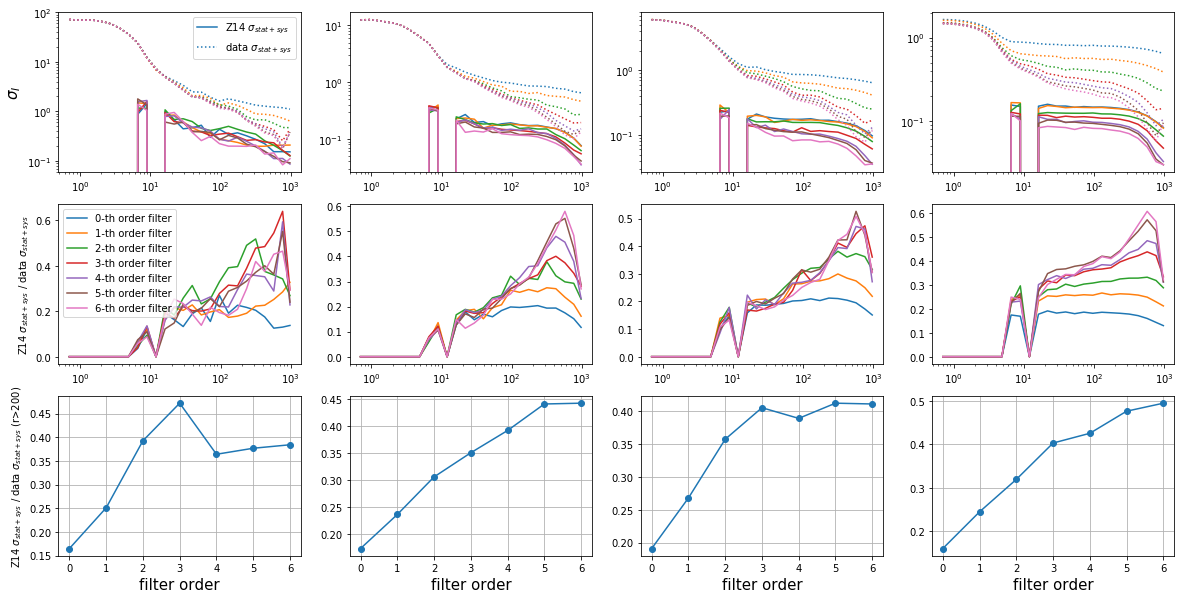

In [17]:
inst = 1
data = data_all[inst]
fig, ax = plt.subplots(3, 4, figsize = (20,10))
ratios = np.zeros([len(filt_order_arr),len(magbindict['m_min'])])      
for ifilt,filt_order in enumerate(filt_order_arr):
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        
        sig_stat = mzdata[filt_order][im]['random_std'] / np.sqrt(5)
        sig_statsys = mzdata[filt_order][im]['region_std'] / np.sqrt(5)
        
        ratios[ifilt,im] = np.mean(sig_statsys[stackdat['rbins']>200] / \
        data[filt_order][im]['jack_region']['profd_err'][stackdat['rbins']>200])

        ax[0][im].loglog(data['rbins'],sig_statsys, c='C'+str(ifilt),label=r'Z14 $\sigma_{stat+sys}$')
        ax[0][im].loglog(data['rbins'],data[filt_order][im]['jack_region']['profd_err'],
                         ':',c='C'+str(ifilt),label=r'data $\sigma_{stat+sys}$')
        
        ax[1][im].semilogx(data['rbins'],sig_statsys/data[filt_order][im]['jack_region']['profd_err'],
                           c='C'+str(ifilt),label='%d-th order filter'%filt_order)

        if ifilt==0:
            ax[-1][im].set_xlabel('r [arcsec]', fontsize=15)
            ax[0][0].legend()

        
ax[0][0].set_ylabel(r'$\sigma_I$', fontsize=15)
ax[1][0].legend()
ax[1][0].set_ylabel(r'Z14 $\sigma_{stat+sys}$ / data $\sigma_{stat+sys}$')

for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    ax[2][im].plot(filt_order_arr, ratios[:,im],'o-')
    ax[2][im].set_xlabel('filter order')
    ax[2][im].grid()
ax[2][0].set_ylabel(r'Z14 $\sigma_{stat+sys}$ / data $\sigma_{stat+sys}$ (r>200)')
    
# plt.savefig('/Users/ytcheng/Desktop/err_data_mz.png',
#             dpi = 150, bbox_inches='tight')

Text(0, 0.5, '$\\sigma_I$')

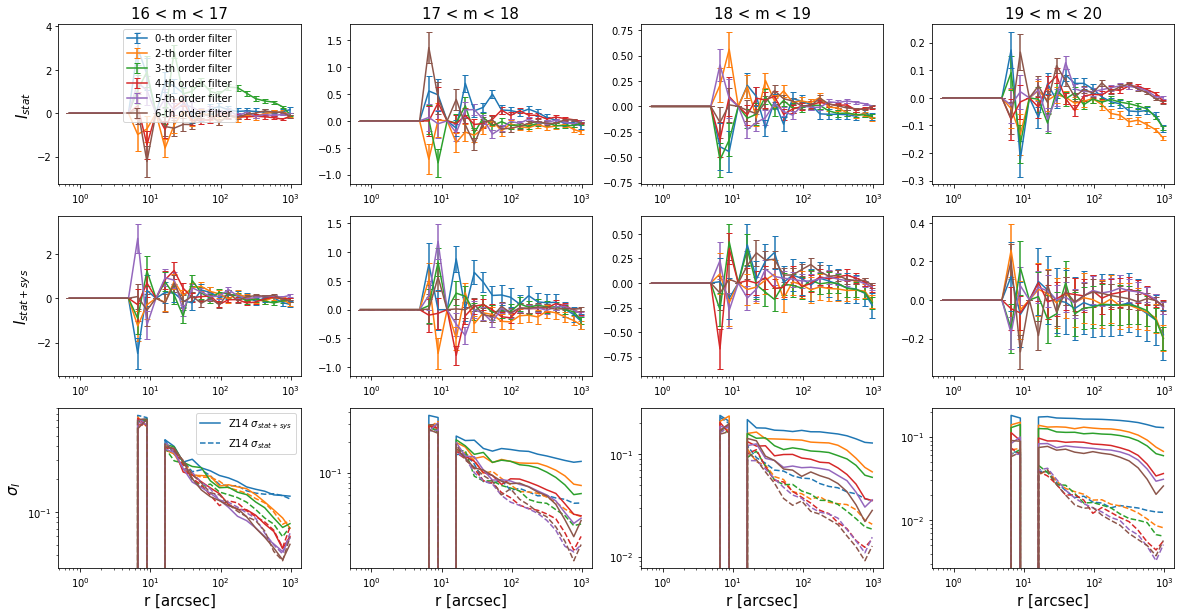

In [3]:
from utils import *
mzdata = np.load('./filt_test_mzdata' + '.npy' ,allow_pickle='TRUE').item()
filt_order_arr = [0,2,3,4,5,6]

fig, ax = plt.subplots(3, 4, figsize = (20,10))
for ifilt,filt_order in enumerate(filt_order_arr):
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        
        sig_stat = mzdata[filt_order][im]['random_std'] / np.sqrt(5)
        sig_statsys = mzdata[filt_order][im]['region_std'] / np.sqrt(5)
        
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[0][im].errorbar(mzdata['rbins'],mzdata[filt_order][im]['random_avg'],
                           sig_stat/8, c='C'+str(ifilt),capsize=3,
                           label='%d-th order filter'%filt_order)
        ax[1][im].errorbar(mzdata['rbins'],mzdata[filt_order][im]['region_avg'],
                           sig_statsys/8, c='C'+str(ifilt),capsize=3)
        ax[2][im].loglog(stackdat['rbins'],sig_statsys/8, c='C'+str(ifilt),label=r'Z14 $\sigma_{stat+sys}$')
        ax[2][im].plot(stackdat['rbins'],sig_stat/8, '--', c='C'+str(ifilt),label=r'Z14 $\sigma_{stat}$')
        ax[1][im].set_xscale('log')
        ax[0][im].set_xscale('log')

        if ifilt==0:
            ax[2][0].legend()
            ax[-1][im].set_xlabel('r [arcsec]', fontsize=15)

ax[0][0].legend()
ax[0][0].set_ylabel(r'$I_{stat}$', fontsize=15)
ax[1][0].set_ylabel(r'$I_{stat+sys}$', fontsize=15)
ax[2][0].set_ylabel(r'$\sigma_I$', fontsize=15)

In [2]:
from stack import *

filt_order_arr = [0,2,3,4,5,6]

data_all = {}
for inst in [1,2]:
    data = {}
    for ifilt,filt_order in enumerate(filt_order_arr):
        data[filt_order] = {}
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            data[filt_order][im] = {}

            profd_arr, profd_err = 0, 0
            profdsub_arr, profdsub_err = 0, 0
            for ifield in [4,5,6,7,8]:
                stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                                    uniform_jack=False,load_from_file=True,BGsub=False).stackdat
                profd_arri = stackdat['BG']['profcb']
                profd_erri = np.sqrt(np.diag(stackdat['BGcov']['profcb']))
                profd_arr += profd_arri / profd_erri**2
                profd_err += 1 / profd_erri**2
                profdsub_arri = stackdat['BG']['profcbsub']
                profdsub_erri = np.sqrt(np.diag(stackdat['BGcov']['profcbsub']))
                profdsub_arr += profdsub_arri / profdsub_erri**2
                profdsub_err += 1 / profdsub_erri**2

            profd_arr /= profd_err
            profd_err = np.sqrt(1 / profd_err)
            profdsub_arr /= profdsub_err
            profdsub_err = np.sqrt(1 / profdsub_err)

            data[filt_order][im]['jack_region'] = {}
            data[filt_order][im]['jack_region']['profd_arr'] = profd_arr
            data[filt_order][im]['jack_region']['profd_err'] = profd_err
            data[filt_order][im]['jack_region']['profdsub_arr'] = profdsub_arr
            data[filt_order][im]['jack_region']['profdsub_err'] = profdsub_err


            data['rbins'] = stackdat['rbins']
            data['rsubbins'] = stackdat['rsubbins']
            
    data_all[inst] = data

Text(0, 0.5, 'Z14 $\\sigma_{stat+sys}$ / data $\\sigma_{stat+sys}$ (r>200)')

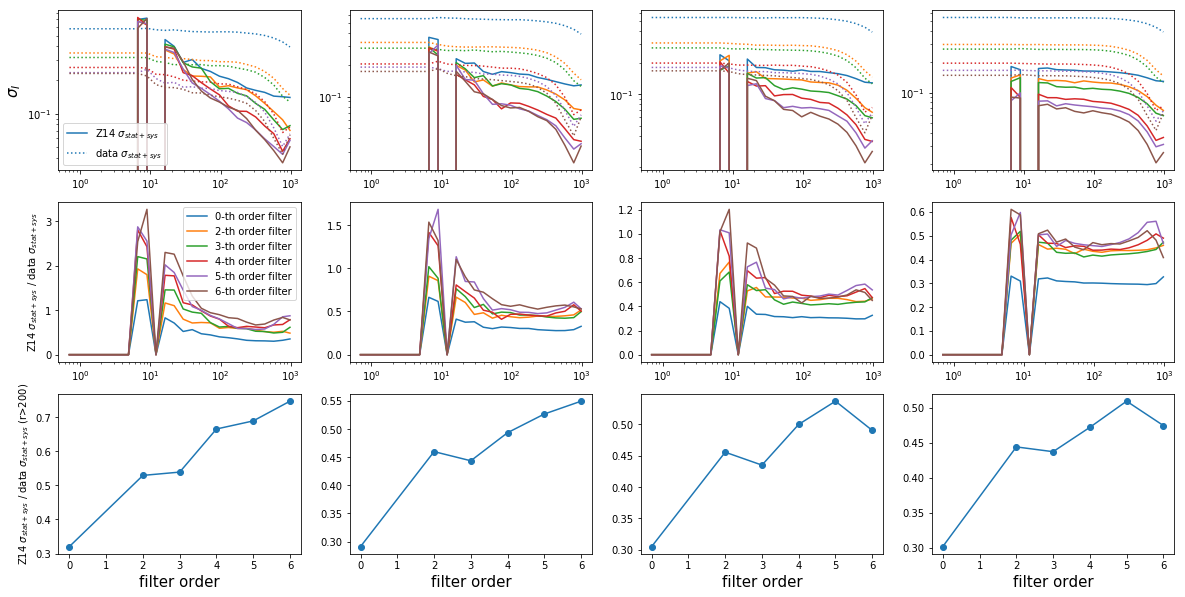

In [8]:
inst = 2
data = data_all[inst]
fig, ax = plt.subplots(3, 4, figsize = (20,10))
ratios = np.zeros([len(filt_order_arr),len(magbindict['m_min'])])      
for ifilt,filt_order in enumerate(filt_order_arr):
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        
        sig_stat = mzdata[filt_order][im]['random_std'] / np.sqrt(5)
        sig_statsys = mzdata[filt_order][im]['region_std'] / np.sqrt(5)
        
        ratios[ifilt,im] = np.mean(sig_statsys[stackdat['rbins']>200] / \
        data[filt_order][im]['jack_region']['profd_err'][stackdat['rbins']>200])

        ax[0][im].loglog(data['rbins'],sig_statsys/8, c='C'+str(ifilt),label=r'Z14 $\sigma_{stat+sys}$')
        ax[0][im].loglog(data['rbins'],data[filt_order][im]['jack_region']['profd_err']/8,
                         ':',c='C'+str(ifilt),label=r'data $\sigma_{stat+sys}$')
        
        ax[1][im].semilogx(data['rbins'],sig_statsys/data[filt_order][im]['jack_region']['profd_err'],
                           c='C'+str(ifilt),label='%d-th order filter'%filt_order)

        if ifilt==0:
            ax[-1][im].set_xlabel('r [arcsec]', fontsize=15)
            ax[0][0].legend()

        
ax[0][0].set_ylabel(r'$\sigma_I$', fontsize=15)
ax[1][0].legend()
ax[1][0].set_ylabel(r'Z14 $\sigma_{stat+sys}$ / data $\sigma_{stat+sys}$')

for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    ax[2][im].plot(filt_order_arr, ratios[:,im],'o-')
    ax[2][im].set_xlabel('filter order')
ax[2][0].set_ylabel(r'Z14 $\sigma_{stat+sys}$ / data $\sigma_{stat+sys}$ (r>200)')
    
# plt.savefig('/Users/ytcheng/Desktop/err_data_mz.png',
#             dpi = 150, bbox_inches='tight')
